In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat

import string
alphabet=list(string.ascii_lowercase)

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

# Read in Data

In [2]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'


In [3]:
if 'hp' in case['name']:
    hp_det_is_fast=True
else:
    hp_det_is_fast=False

In [4]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-hp_cy5 gzCOBALT-hp_cy5


In [5]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [6]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5


In [7]:
# read in files
diagTypes = ['ocean_cobalt_omip_rates_year_z'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension


In [8]:
if not files:
    pp_path=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)


['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5/ocean_cobalt_omip_rates_year_z.1988-2007.nc']


In [9]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [10]:
tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_rates_year_z'] 

pp_dates='1988-2007'

c_files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension
print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5
['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_rates_year_z.1988-2007.nc']


In [11]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [12]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

# Calculate export and transfer efficiency at 1000m

In [13]:
ds = ds.isel(time=0)
dc = dc.isel(time=0)

In [14]:
print(ds.z_l.values[6], ds.z_l.values[13], ds.z_l.values[18], ds.z_l.values[25])

100.0 500.0 1000.0 2062.5


In [15]:
print(ds.expc.attrs['long_name'])
print(ds.expc.attrs['units'])

Sinking Particulate Organic Carbon Flux
mol m-2 s-1


In [16]:
flux100 = ds.expc.sel(z_l=100.)
flux500 = ds.expc.sel(z_l=500.)
flux1000 = ds.expc.sel(z_l=1000.)

c_flux100 = dc.expc.sel(z_l=100.)
c_flux500 = dc.expc.sel(z_l=500.)
c_flux1000 = dc.expc.sel(z_l=1000.)

In [17]:
val=(flux1000*grid.areacello).sum().values*carbon_molar_mass*seconds_per_year
print('Sequestration flux to 1000m (fastPOC): '+ str(np.round(val/1e15,2)) + ' Pg C/yr')

c_val=(c_flux1000*grid.areacello).sum().values*carbon_molar_mass*seconds_per_year
print('Sequestration flux to 1000m (Ctrl): '+ str(np.round(c_val/1e15,2)) + ' Pg C/yr')

pct_diff = (val-c_val)/c_val
print('Percent difference: '+ str(np.round(pct_diff*100,2)) + ' %')

factor_diff = val/c_val
print('Factor difference: '+ str(np.round(factor_diff,2)))

Sequestration flux to 1000m (fastPOC): 1.02 Pg C/yr
Sequestration flux to 1000m (Ctrl): 0.84 Pg C/yr
Percent difference: 21.3 %
Factor difference: 1.21


In [18]:
te1000 = flux1000 / flux100
c_te1000 = c_flux1000 / c_flux100


# Plot

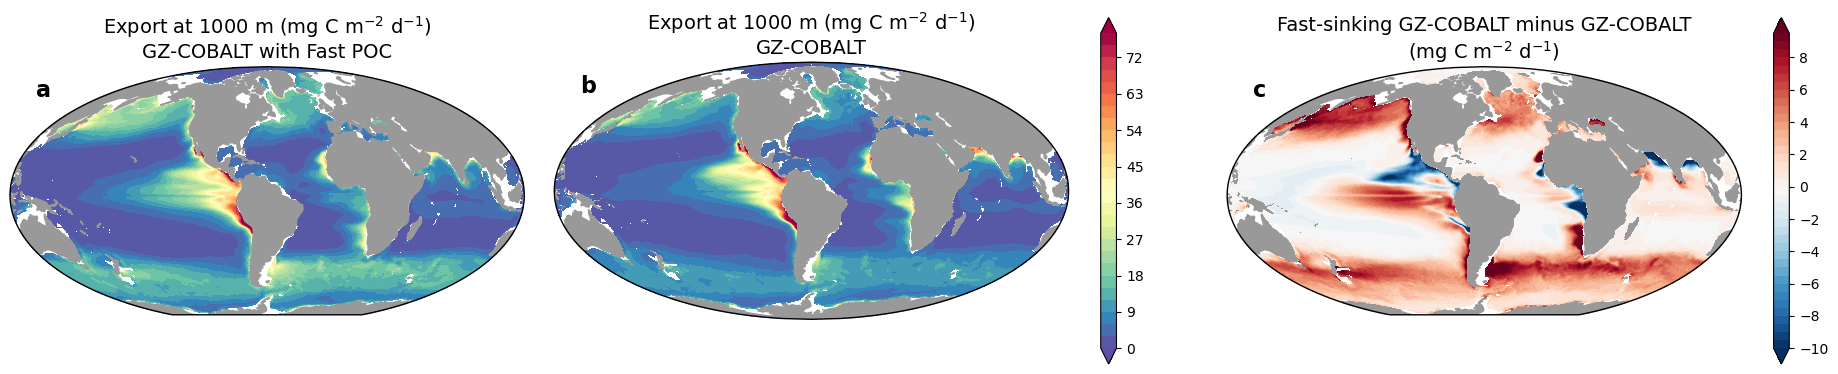

In [19]:
fig=plt.figure(figsize=(24,6))
gs=gridspec.GridSpec(1,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}

levels=np.arange(0,80,3)

fastgz=flux1000 * seconds_per_day * carbon_molar_mass * 1e3
ctrlgz=c_flux1000 * seconds_per_day * carbon_molar_mass * 1e3
# HP ingestion
i=0
field=fastgz
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='#999999')
ax[i].set_title('Export at 1000 m (mg C m$^{-2}$ d$^{-1}$)\nGZ-COBALT with Fast POC', fontsize=14)

ax[i].text(0.05, 0.95, 'a', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

i=1
field=ctrlgz
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Export at 1000 m (mg C m$^{-2}$ d$^{-1}$)\nGZ-COBALT', fontsize=14)
ax[i].text(0.05, 0.95, 'b', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

i=2
field=fastgz-ctrlgz
levels=np.arange(-10,10,0.5)
ax[i] = plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Fast-sinking GZ-COBALT minus GZ-COBALT\n(mg C m$^{-2}$ d$^{-1}$)', fontsize=14)
ax[i].text(0.05, 0.95, 'c', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_SequestrationFlux_Comparison.png', dpi=300, bbox_inches='tight')


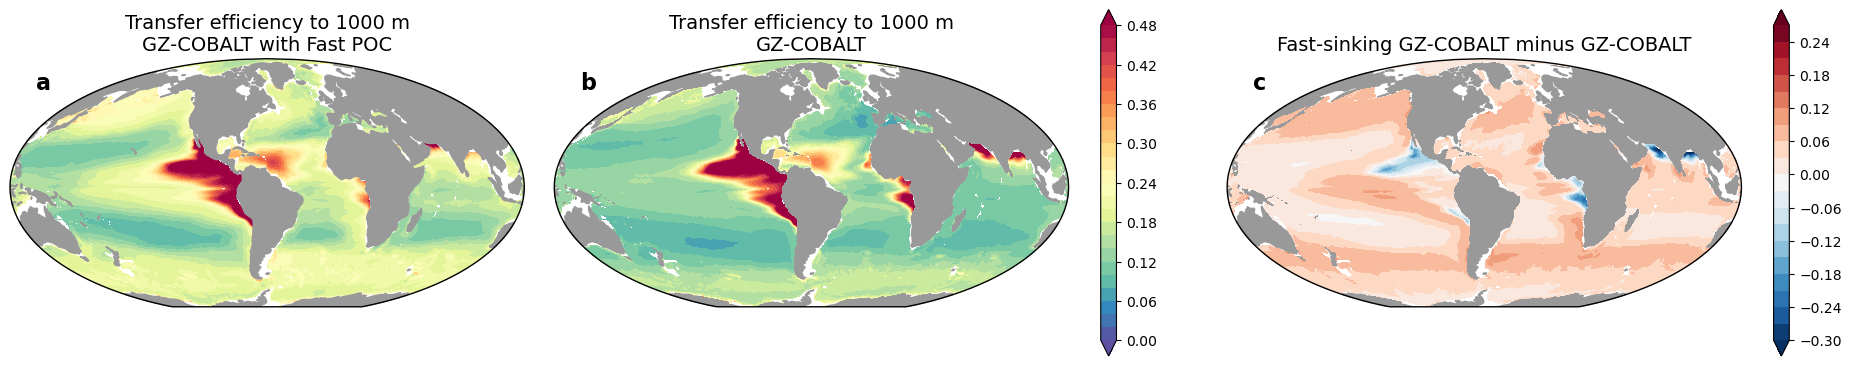

In [20]:
fig=plt.figure(figsize=(24,6))
gs=gridspec.GridSpec(1,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}

levels=np.arange(0,0.5,.02)

fastgz=te1000
ctrlgz=c_te1000

i=0
field=fastgz
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='#999999')
ax[i].set_title('Transfer efficiency to 1000 m\nGZ-COBALT with Fast POC', fontsize=14)

ax[i].text(0.05, 0.95, 'a', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

i=1
field=ctrlgz
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Transfer efficiency to 1000 m\nGZ-COBALT', fontsize=14)
ax[i].text(0.05, 0.95, 'b', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

i=2
field=fastgz-ctrlgz
levels=np.arange(-0.3,0.3,0.03)
ax[i] = plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Fast-sinking GZ-COBALT minus GZ-COBALT', fontsize=14)
ax[i].text(0.05, 0.95, 'c', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_TransferEfficiency_Comparison.png', dpi=300, bbox_inches='tight')
